# 18.S096 Matrix Calculus Pset 2 Solutions

MIT Department of Mathematics, January 2024.

## Problem 2

This problem uses the `stencil` program from [these course notes on finite differences](https://github.com/mitmath/matrixcalc/blob/a2c2d3c5f9269f501fa03cd14e3fbe8d219df211/notes/Finite%20difference%20checks.ipynb), originating from [this post](https://discourse.julialang.org/t/generating-finite-difference-stencils/85876/5?u=stevengj):

In [1]:
function stencil(x::AbstractVector{<:Real}, x₀::Real, m::Integer)
    ℓ = 0:length(x)-1
    m in ℓ || throw(ArgumentError("order $m ∉ $ℓ"))
    A = @. (x' - x₀)^ℓ / factorial(ℓ)
    return A \ (ℓ .== m) # vector of weights w
end

stencil (generic function with 1 method)

A function to compute relative errors will also be useful in this pset:

In [2]:
using LinearAlgebra # for norm
relerr(approx, exact) = norm(approx - exact) / norm(exact)

relerr (generic function with 1 method)

### part 2.2

We evaluate it for `x = [0, 1]` and `x₀ = 0` for the `m = 1` (first) derivative.  In Julia, we can pass `x₀ = 0//1` to use the [rational-number type](https://docs.julialang.org/en/v1/manual/complex-and-rational-numbers/#Rational-Numbers) in order to obtain exact rational results:

In [3]:
stencil([0, 1], 0//1, 1)

2-element Vector{Rational{Int64}}:
 -1
  1

As discussed in the solutions, these weights `w = [-1, 1]` correspond exactly to the usual first-order forward-difference rule.

### part 2.3

Now we evaluate it with `x = [0,1,2,3] == 0:3` and `x₀ = 0//1` for `m = 1` to obtain a higher-order rule for more points:

In [4]:
w = stencil(0:3, 0//1, 1)

4-element Vector{Rational{Int64}}:
 -11//6
    3
  -3//2
   1//3

We will now use these weights $w = [-11/6, 3, -3/2, 1/3]$ to estimate $\sin'(1)$ for a range of $h$ values to determine the order of accuracy, similar to the course notebook:

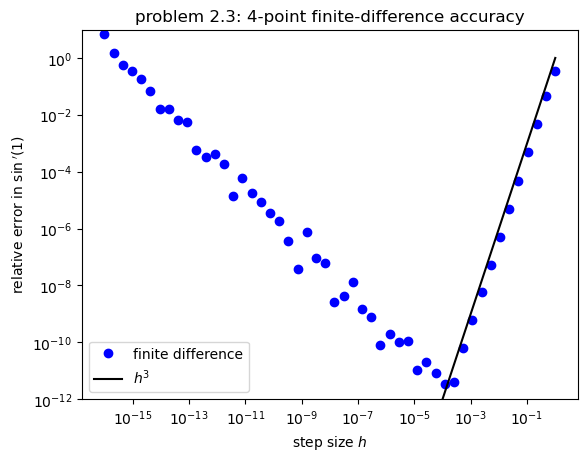

PyObject Text(0.5, 28.0, 'step size $h$')

In [5]:
h = exp10.(range(-16, 0, length=50)) # log-spaced h from 10⁻¹⁶ to 10⁰
fd = [sum(w .* sin.(1 .+ h .* (0:3)))/h for h in h] # finite-difference results
exact = cos(1) # the exact derivative

using PyPlot
loglog(h, relerr.(fd, exact), "bo")
loglog(h, h.^3, "k-")
ylim(1e-12, 1e1)
legend(["finite difference", L"h^3"])
title("problem 2.3: 4-point finite-difference accuracy")
ylabel(L"relative error in $\sin'(1)$")
xlabel(L"step size $h$")

Here, we've plotted the line $h^3$ for reference, and it is absolutely clear that the finite-difference truncation error is very nearly parallel to this.  Our 4-point finite-difference formula has **third-order accuracy**.

(As in class, once $h$ becomes small enough, the error starts increasing again, but that is due to the separate phenomenon of floating-point cancellation error.)

## Problem 3

First, let us define the function $g(x,p)$ from the problem set as Julia code, where `x` and `p` are arrays of length 2 and 3, respectively:

In [6]:
g(x, p) = [p[1]*x[1]^2 - x[2],
           x[1]*x[2] - p[2]*x[2] + p[3]]

g (generic function with 1 method)

For $p = [1,2,1]$ we should have an exact root for $x = [1,1]$.  Let's check:

In [7]:
p = [1,2,1]
g([1,1], p)

2-element Vector{Int64}:
 0
 0

### part 3.1

For part 3.1, you were asked to compute the Jacobian matrices $\frac{\partial g}{\partial x}$ and $\frac{\partial g}{\partial x}$ analytically.

We could use these as Julia functions for parts 3.2 and 3.3, so let's implement them here:

In [8]:
# ∂g/∂x:
gₓ(x, p) = [2p[1]*x[1]  -1
            x[2]        x[1]-p[2]]

# ∂g/∂p:
gₚ(x, p) = [x[1]^2  0     0
            0      -x[2]  1]

gₚ (generic function with 1 method)

#### Extra:

You were *not required* to do this, but for fun let's check our Jacobians against the Julia [ForwardDiff.jl AD package](https://github.com/JuliaDiff/ForwardDiff.jl) at some random point, with the help of the `relerr` function defined above:

In [9]:
using ForwardDiff

# random x and p
xr, pr = randn(2), randn(3)

relerr(gₓ(xr,pr), ForwardDiff.jacobian(x -> g(x,pr), xr)),
  relerr(gₚ(xr,pr), ForwardDiff.jacobian(p -> g(xr,p), pr))

(0.0, 0.0)

Hooray, the errors are ≈zero for both Jacobians!

### part 3.2

Here, we will implement a Newton iteration to solve $g(x) = 0$ for a given function $g$.

We could specialize it for our particular function $g(x,p)$ here, but it is even nicer to write a function that works in general: it takes an arbitrary function `g` as an argument, and uses ForwardDiff to comptue the Jacobian.  (This is an example of a [higher-order function](https://en.wikipedia.org/wiki/Higher-order_function).)

It stops after `n` iters or when a given relative tolerance `tol` in `x` is reached, whatever comes first.

We'll also print the value of the solution on each step so that we can watch the progress:

In [10]:
function newton(g, x; n=1000, tol=eps(float(one(eltype(x))))*10)
    for iteration = 1:n
        J = ForwardDiff.jacobian(g, x) # Jacobian at x by AD!
        
        δx = J \ g(x) # Newton step
        x = x - δx
        
        @show iteration, x
        
        # stop if ‖δx‖ ≤ tol ‖x‖:
        norm(δx) ≤ tol * norm(x) && break
    end
    return x
end
    

newton (generic function with 1 method)

Now, we will apply it to the function $g(x,p)$ that we are using here, with the suggested starting point of `x = [1.2, 1.3]`:

In [11]:
newton(x -> g(x, [1,2,1]), [1.2, 1.3])

(iteration, x) = (1, [0.9548387096774194, 0.8516129032258064])
(iteration, x) = (2, [0.9960065802133641, 0.9903343142638562])
(iteration, x) = (3, [0.9999776274777928, 0.9999394862397392])
(iteration, x) = (4, [0.9999999991467472, 0.9999999977930027])
(iteration, x) = (5, [1.0, 1.0])
(iteration, x) = (6, [1.0, 1.0])


2-element Vector{Float64}:
 1.0
 1.0

Hooray, it converged to $x = [1, 1]$ as desired, and to machine precision in **only 5 iterations**!

You can clearly see the number of digits roughly doubling in each step, which is known as "quadratic convergence".

### part 3.3

From the solutions, for $f(p) = \Vert x(p) \Vert$, we now want to compute 
$$
\nabla f = -\left(\frac{\partial g}{\partial p}\right)^T \left[ \underbrace{ \left(\frac{\partial g}{\partial x} \right)^{-T} \frac{x}{\Vert x \Vert}}_v \right] 
$$
at $p = [1,2,1]$ and the corresponding $x = [1,1]$.  Applying either our analytical Jacobians or the AD Jacobian, this is simply given by:

In [12]:
p = [1,2,1]
x = [1,1]

v = gₓ(x,p)' \ x / norm(x)  # adjoint solve (note ' = transpose)
∇f = -gₚ(x,p)' * v

3-element Vector{Float64}:
 -1.414213562373095
 -2.1213203435596424
  2.1213203435596424

This exactly matches the analytical answer from the solutions:

In [13]:
relerr(∇f, [-2,-3,3]/sqrt(2))

0.0

Now, let's compare it to a finite-difference approximation for a random small $\delta p$:

In [14]:
δp = randn(3) * 1e-8
δx = newton(x -> g(x, p+δp), x) - x

(iteration, x) = (1, [0.9999999952472146, 0.9999999910684964])
(iteration, x) = (2, [0.9999999952472147, 0.9999999910684965])


2-element Vector{Float64}:
 -4.752785276451732e-9
 -8.931503536757646e-9

Not surprisingly, Newton converged almost immediately starting from $x = [1,1]$, since a small change in $p$ leads to a small change in $x$.  Now, let's compute the change in $f(x) = \Vert x \Vert$:

In [15]:
δf = norm(x + δx) - norm(x)

-9.676253576174076e-9

and compare it to the derivative prediction $(\nabla f)^T \delta p$:

In [16]:
∇f'δp

-9.676253736858523e-9

Hooray, they match very well!  More quantitatively, the relative difference is:

In [17]:
relerr(δf, ∇f'δp)

1.6606059609148775e-8

i.e. they **match to almost 8 significant digits**, which makes it very unlikely that we have a bug in our calculation.   (The difference here is dominated by the error in the finite-difference calculation.)

#### Extra:

You were *not required* to do this, but for fun we can also use ForwardDiff.jl to compute $\nabla f$ by automatic differentiation.  It doesn't know that we are solving $g(x,p) = 0$ and does not use the implicit-function theorem — instead, it will simply propagate the chain rule through the Newton iteration.  But it should arrive at the same result:

In [18]:
 ad_∇f = ForwardDiff.gradient(p -> norm(newton(x -> g(x,p), x)), p)

(iteration, x) = (1, ForwardDiff.Dual{ForwardDiff.Tag{var"#12#14", Int64}, Float64, 3}[Dual{ForwardDiff.Tag{var"#12#14", Int64}}(1.0,-1.0,-1.0,1.0), Dual{ForwardDiff.Tag{var"#12#14", Int64}}(1.0,-1.0,-2.0,2.0)])


3-element Vector{Float64}:
 -1.414213562373095
 -2.1213203435596424
  2.1213203435596424

Yup, it matches our analytical result to machine precision!

In [19]:
relerr(ad_∇f, ∇f)

0.0

## Problem 4

Here, we need to compute the gradient of $f(A) = \det(A + \exp(A))$, and in the solutions we derived the formula:
$$
\nabla f = \det(X) (X^{-T} + \exp'(A^T)[X^{-T}]) \, ,
$$
where $X = A + \exp(A)$ and $\exp'$ is the derivative of a matrix exponential.  From pset~1, we also know that we can compute the derivative of a matrix exponential by
$$
\exp \begin{pmatrix} A & X \\ & A \end{pmatrix}
= \begin{pmatrix} \exp(A) & \exp'(A)[X] \\ & \exp(A) \end{pmatrix}
$$
(although there are other, more efficient algorithms).

So, we can implement this function and its gradient as follows:

In [20]:
using LinearAlgebra

f₄(A) = det(A + exp(A))
    
function ∇f₄(A)
    m = LinearAlgebra.checksquare(A)
    X = A + exp(A)
    X⁻ᵀ = inv(X')
    exp′ = exp([A' X⁻ᵀ; 0I A'])[1:m,m+1:end] # exp′(Aᵀ)[X⁻ᵀ]
    return det(X) * (X⁻ᵀ + exp′)
end

∇f₄ (generic function with 1 method)

Now, let's check it against finite differences for random 5×5 matrices:

In [21]:
A = randn(5,5)
δA = randn(5,5) * 1e-8

δf₄ = f₄(A + δA) - f₄(A) # finite difference

3.135265941978105e-6

In [22]:
dot(∇f₄(A), δA) # Frobenius inner product

3.1352661915344877e-6

Hooray, they clearly match pretty well!

More quantitatively, we can compute the relative error using the `relerr` function we defined above:

In [23]:
relerr(δf₄, dot(∇f₄(A), δA))

7.959655340682903e-8

It matches to **more than 7 digits**, which is about as much as we can hope for from our finite-difference approximation.   This is a pretty strong indication that we computed $\nabla f$ correctly.

#### Extra:

For fun, we could also try automatic differentiation.

Unfortunately, ForwardDiff.jl currently doesn't know how to differentiate through a matrix exponential:

In [24]:
ForwardDiff.gradient(f₄, A)

LoadError: MethodError: no method matching exp!(::Matrix{ForwardDiff.Dual{ForwardDiff.Tag{typeof(f₄), Float64}, Float64, 9}})

[0mClosest candidates are:
[0m  exp!([91m::StridedMatrix{T}[39m) where T<:Union{Float32, Float64, ComplexF64, ComplexF32}
[0m[90m   @[39m [35mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.0+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mdense.jl:649[24m[39m


Also, in any case, forward-mode AD is a dubious idea for computing matrix gradients, or any gradients with lots of components.  You probably want to use reverse-mode AD.

We can try the [Zygote.jl](https://github.com/FluxML/Zygote.jl) reverse-mode AD package in Julia, which knows how to differentiate matrix exponentials via the [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) package, which uses an algorithm by [Al-Mohy and Higham (2009)](https://epubs.siam.org/doi/10.1137/080716426):

In [25]:
import Zygote
Zygote.gradient(f₄, A)[1]

5×5 Matrix{Float64}:
 -171.689    45.6721   -96.4915   29.7787   192.543
 -260.562    34.6352  -148.865    33.9207   321.104
   83.6788  -24.708     23.3438  -27.8848  -100.817
 -239.694    71.3642  -126.107    83.5932   272.016
 -108.063    17.6445   -53.4481   10.6855    99.6138

Hooray, at least it gives us *something*.  Let's check that it matches our answer:

In [26]:
relerr(Zygote.gradient(f₄, A)[1], ∇f₄(A))

1.1932523224923703e-15

Hooray, it matches our result to nearly machine precision!